 <p style = "font-size: 35px;font-weight: bold;text-align:center;color:#800000"> Ecosure Violations & Review Sentiment All Brands Analysis </p>

<div>
    <img src = "http://upload.wikimedia.org/wikipedia/en/0/0c/Mu_Sigma_Logo.jpg" align="left" style="height:100px;margin-right:100px">
</div>
<div>
    <img src = "https://upload.wikimedia.org/wikipedia/commons/2/26/Ecolab.svg" align="right" style="height:40px;margin-left:100px; margin-top:25px">
</div>

<p style="font-size:100%;text-align:left;font-weight:bold"> Created by  : Mu Sigma team for Ecolab
<p style="font-size:100%;text-align:left;font-weight:bold;"> Last edited : 05/27/2021

 <p style = "font-size: 20px;font-weight: bold;text-align: left;color:#000000"> Description:   </p>
 
This notebook is used to explore the relationship between the drivers and measures. We are comparing audits data with sentiment scores and rating.<br>

Data Used: <br>
* For <b>Audit Information</b>, across different brands, we have used <b>Ecosure BI Data</b> stored in <b>SQLServer</b>
* For <b>Sentiment Information</b>, across different brands, we have used different review sample pulled from <b>Yelp API</b> and run a Sentiment model using Flair

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import pandas as pd
import numpy as np
import os
import warnings
import itertools
import datetime
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.stats.stats import pearsonr
from scipy import stats
import matplotlib
import seaborn as sns
import pytz
import pyodbc
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
utc=pytz.UTC
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 2000)
pd.options.display.float_format = '{:.2f}'.format

In [3]:
######################################################### Audit Data ###################################################################
########################################################################################################################################

df_audit = pd.read_csv('./csv/EcosureAudits80.csv')

# Aggregating data at month year level
df_audit['AuditStarted'] = pd.to_datetime(df_audit['AuditStarted'], errors='coerce')
df_audit['Date'] = df_audit['AuditStarted'].dt.date
df_audit['month_year'] = df_audit['Date'].apply(lambda x: x.strftime('%B-%Y'))

df_violations = df_audit.groupby(['month_year', 'ClientName'], as_index=False).agg({'Level1_Violations' : 'sum', 'Level2_Violations' : 'sum',
                                                                                    'Level3_Violations' : 'sum', 'Score' : 'mean', 
                                                                                    'ClientID' : 'count'})

# Renaming Columns
df_violations.rename({'Level1_Violations' : 'Minor_Violations', 
                      'Level2_Violations' : 'Major_Violations',
                      'Level3_Violations' : 'Critical_Violations',
                      'Score' : 'Mean_Audit_Score',
                      'ClientName' : 'Brand',
                      'ClientID' : 'No_of_Audits'},axis=1, inplace=True)

# Adding KPIs
df_violations['Total_No_of_Violations'] = df_violations['Minor_Violations'] + df_violations['Major_Violations'] + df_violations['Critical_Violations']

# Adding Normalized KPIs
df_violations['Minor_Violations_per_audit'] = df_violations['Minor_Violations']/df_violations['No_of_Audits']
df_violations['Major_Violations_per_audit'] = df_violations['Major_Violations']/df_violations['No_of_Audits']
df_violations['Critical_Violations_per_audit'] = df_violations['Critical_Violations']/df_violations['No_of_Audits']
df_violations['Total_No_of_Violations_per_audit'] = df_violations['Total_No_of_Violations']/df_violations['No_of_Audits']

# Ordering by month
new_orders = ['September-2016', 'October-2016',  'November-2016', 'December-2016', 'January-2017', 'February-2017', 'March-2017', 'April-2017',
              'May-2017', 'June-2017', 'July-2017', 'August-2017', 'September-2017', 'October-2017', 'November-2017', 'December-2017',
              'January-2018', 'February-2018','March-2018','April-2018', 'May-2018', 'June-2018', 'July-2018', 'August-2018', 'September-2018',
              'October-2018', 'November-2018', 'December-2018', 'January-2019', 'February-2019', 'March-2019', 'April-2019', 
              'May-2019', 'June-2019', 'July-2019', 'August-2019', 'September-2019', 'October-2019', 'November-2019', 'December-2019',
              'January-2020', 'February-2020', 'March-2020', 'April-2020', 'May-2020', 'June-2020', 'July-2020', 'August-2020',
              'September-2020', 'October-2020', 'November-2020', 'December-2020','January-2021', 'February-2021', 'March-2021', 'April-2021']

df_violations['month_year'] = pd.Categorical(df_violations['month_year'], categories=new_orders, ordered=True)
df_violations.sort_values(by=['month_year'], ascending=True, inplace=True)
df_violations = df_violations[df_violations.month_year.notnull()]

In [4]:
print("Total No of unique brands used for analysis:", df_audit.ClientName.nunique())
print('\n \n')
print("Name's of the brands used for analysis:", df_audit.ClientName.unique())

Total No of unique brands used for analysis: 20

 

Name's of the brands used for analysis: ['Panera' 'IHOP' 'Buffalo Wild Wings' 'Noodles & Co.'
 "Famous Dave's of America,  Inc." 'True Food Kitchen' 'Twin Peaks'
 'Benihana National Corp' 'On the Border' "Applebee's" 'Texas Roadhouse'
 "Friendly's" 'Margaritaville' 'Cafe Zupas' 'Ruby Tuesday Inc.' 'WingStop'
 'Four Corners Tavern Group' 'Modern Market' 'Wood Ranch'
 "O'Charley's, Inc."]


In [5]:
########################################################## Reviews Data #################################################################
#########################################################################################################################################

# Reading reviews data
# df_panera  = pd.read_csv('./csv/Panera_Bread.csv')
# df_panera = df_panera.loc[:, ~df_panera.columns.str.contains('^Unnamed')]
# df_panera['Brand'] = 'Panera'

# df_ihop  = pd.read_csv('./csv/Ihop.csv')
# df_ihop = df_ihop.loc[:, ~df_ihop.columns.str.contains('^Unnamed')]
# df_ihop['Brand'] = 'IHOP'

# df_buffalow = pd.read_csv('./csv/Buffalow_Wild_Wings.csv')
# df_buffalow = df_buffalow.loc[:, ~df_buffalow.columns.str.contains('^Unnamed')]
# df_buffalow['Brand'] = 'Buffalo Wild Wings'

# df_noodles = pd.read_csv('./csv/Noodles_Company.csv')
# df_noodles = df_noodles.loc[:, ~df_noodles.columns.str.contains('^Unnamed')]
# df_noodles['Brand'] = 'Noodles & Co.'

# df_benihana = pd.read_csv('./csv/Benihana.csv')
# df_benihana = df_benihana.loc[:, ~df_benihana.columns.str.contains('^Unnamed')]
# df_benihana['Brand'] = 'Benihana National Corp'

# df_ontheboard = pd.read_csv('./csv/On_the_Border.csv')
# df_ontheboard = df_ontheboard.loc[:, ~df_ontheboard.columns.str.contains('^Unnamed')]
# df_ontheboard['Brand'] = 'On the Border'

# df_applebees = pd.read_csv('./csv/Applebees.csv')
# df_applebees = df_applebees.loc[:, ~df_applebees.columns.str.contains('^Unnamed')]
# df_applebees['Brand'] = "Applebee's"

df_friendlys = pd.read_csv('/User/yelpapi/Sentiment/Friendlys.csv')
df_friendlys = df_friendlys.loc[:, ~df_friendlys.columns.str.contains('^Unnamed')]
df_friendlys['Brand'] = "Friendly's"

df_margaritaville = pd.read_csv('/User/yelpapi/Sentiment/Margaritaville.csv')
df_margaritaville = df_margaritaville.loc[:, ~df_margaritaville.columns.str.contains('^Unnamed')]
df_margaritaville['Brand'] = 'Margaritaville'

# df_rubytuesday = pd.read_csv('./csv/Ruby_Tuesday.csv')
# df_rubytuesday = df_rubytuesday.loc[:, ~df_rubytuesday.columns.str.contains('^Unnamed')]
# df_rubytuesday['Brand'] = 'Ruby Tuesday Inc.'

# df_wingstop = pd.read_csv('./csv/Wing_Stop.csv')
# df_wingstop = df_wingstop.loc[:, ~df_wingstop.columns.str.contains('^Unnamed')]
# df_wingstop['Brand'] = 'Ruby Tuesday Inc.'

df_modmarket = pd.read_csv('/User/yelpapi/Sentiment/Modern_Market.csv')
df_modmarket = df_modmarket.loc[:, ~df_modmarket.columns.str.contains('^Unnamed')]
df_modmarket['Brand'] = 'Modern Market'

df_truefood = pd.read_csv('/User/yelpapi/Sentiment/True_Food_Kitchen.csv')
df_truefood = df_truefood.loc[:, ~df_truefood.columns.str.contains('^Unnamed')]
df_truefood['Brand'] = 'True Food Kitchen'

# df_txroadhouse = pd.read_csv('./csv/Texas_Roadhouse.csv')
# df_txroadhouse = df_txroadhouse.loc[:, ~df_txroadhouse.columns.str.contains('^Unnamed')]
# df_txroadhouse['Brand'] = 'Texas Roadhouse'

df_famousdave = pd.read_csv('/User/yelpapi/Sentiment/Famous_Dave.csv')
df_famousdave = df_famousdave.loc[:, ~df_famousdave.columns.str.contains('^Unnamed')]
df_famousdave['Brand'] = "Famous Dave's of America, Inc."

df_zupas = pd.read_csv('/User/yelpapi/Sentiment/Cafe_Zupas.csv')
df_zupas = df_zupas.loc[:, ~df_zupas.columns.str.contains('^Unnamed')]
df_zupas['Brand'] = 'Cafe Zupas'

# df_fourcorners = pd.read_csv('./csv/Four_Corners.csv')
# df_fourcorners = df_fourcorners.loc[:, ~df_fourcorners.columns.str.contains('^Unnamed')]
# df_fourcorners['Brand'] = 'Four Corners Tavern Group'

# df_charleys = pd.read_csv('./csv/O_Charleys.csv')
# df_charleys = df_charleys.loc[:, ~df_charleys.columns.str.contains('^Unnamed')]
# df_charleys['Brand'] = "O'Charley's, Inc."

# df_twinpeaks = pd.read_csv('./csv/Twin_Peaks.csv')
# df_twinpeaks = df_twinpeaks.loc[:, ~df_twinpeaks.columns.str.contains('^Unnamed')]
# df_twinpeaks['Brand'] = 'Twin Peaks'

df_woodranch = pd.read_csv('/User/yelpapi/Sentiment/Wood_Ranch.csv')
df_woodranch = df_woodranch.loc[:, ~df_woodranch.columns.str.contains('^Unnamed')]
df_woodranch['Brand'] = 'Wood Ranch'

df_review = df_modmarket.append([df_friendlys, df_margaritaville, df_truefood,
                                 df_famousdave, df_zupas, df_woodranch])

df_review = df_review[df_review['date'].notnull()]

# Getting Month-Year from date
df_review['Date'] = pd.to_datetime(df_review['date'], errors='coerce')
df_review['Date'] = df_review['Date'].dt.date
df_review['month_year'] = df_review['Date'].apply(lambda x: x.strftime('%B-%Y'))

# Flags to be used in aggregation
df_review['Negative_flag'] = np.where(df_review['Flair_Score'] < 0,1,0)
df_review['Positive_flag'] = np.where(df_review['Flair_Score'] > 0,1,0)

df_grouped_review = df_review.groupby(['month_year', 'Brand'], as_index=False).agg({'Flair_Score' : 'mean',
                                                                           'Positive_flag' : 'sum',
                                                                           'Negative_flag' : 'sum',
                                                                           'rating' : 'mean',
                                                                           'text' : 'count'})
df_grouped_review.rename({'text' : 'No_of_Reviews',
                          'rating' : 'Rating',
                          'Positive_flag': 'Positive_Reviews',
                          'Negative_flag': 'Negative_Reviews'}, axis=1, inplace=True)

# Calculating KPIs
df_grouped_review['Positive_Review_Percent'] = (df_grouped_review['Positive_Reviews']/df_grouped_review['No_of_Reviews'])*100
df_grouped_review['Negative_Review_Percent'] = (df_grouped_review['Negative_Reviews']/df_grouped_review['No_of_Reviews'])*100

In [6]:
df_grouped_review.Brand.unique()

array(["Friendly's", 'Cafe Zupas', "Famous Dave's of America, Inc.",
       'Margaritaville', 'Modern Market', 'Wood Ranch',
       'True Food Kitchen'], dtype=object)

In [7]:
df_violations = df_violations[df_violations['Brand'].isin(["Friendly's", 'Cafe Zupas', "Famous Dave's of America, Inc.",
                                                           'Margaritaville', 'Modern Market', 'Wood Ranch', 'True Food Kitchen'])]
df_violations.reset_index(drop=True, inplace=True)

In [8]:
############################################# Merging Both the Datasets #################################################################
#########################################################################################################################################

df_merged = pd.merge(df_violations, df_grouped_review, how='inner', on=['month_year', 'Brand'])

df_merged['month_year'] = pd.Categorical(df_merged['month_year'], categories=new_orders, ordered=True)
df_merged.sort_values(by=['month_year'], ascending=True, inplace=True)
df_merged.reset_index(drop=True, inplace=True)
# df_merged.dropna(how = 'any', axis=0, inplace=True)

# Adding KPI for normalised store
grouped_brands = df_audit.groupby(['ClientName']).agg({'State': pd.Series.nunique ,
                                                       'City': pd.Series.nunique,
                                                       'StoreName':pd.Series.nunique,
                                                       'ClientID': 'count' }).reset_index()
dicti = dict(zip(list(grouped_brands.ClientName), list(grouped_brands.StoreName)))

def kpi_audit_store(brand, audits):
    return (audits/dicti[brand])

df_merged['Audit_per_store'] = df_merged.apply(lambda x: kpi_audit_store(x['Brand'], x['No_of_Audits']), axis=1)

In [9]:
######################################################## PLOTS FUNCTIONS ###################################################

def barplots_func(X, Y, DF, X_LABEL, Y_LABEL, TITLE):
    plt.figure(figsize=(10,7))
    ax = sns.barplot(x=X, y=Y, data=DF, palette="deep")
    ax.set(xlabel = X_LABEL, ylabel = Y_LABEL)
    ax.set_title(TITLE)
    plt.xticks(rotation=90)
    plt.show()
    
def dual_ax_plots(X, Y1, Y2, DF, X_LABEL, Y1_LABEL, Y2_LABEL, TITLE):
    plt.figure(figsize=(15,7))
    color = 'darkgreen'
    ax1 = sns.lineplot(x=X, y=Y1, data=DF, color=color, marker='o')
    ax1.set_ylabel(color=color, ylabel='')
    ax1.set(xlabel = X_LABEL, ylabel = Y1_LABEL)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_title(TITLE)
    ax1.grid(True)
    plt.xticks(rotation=90)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'darkred'
    ax2 = sns.lineplot(x=X, y=Y2, data=DF, color=color, marker='o')
    ax2.set_ylabel(color=color, ylabel='')
    ax2.set(ylabel = Y2_LABEL)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()
    
def req_intervals(x):
    if (x < -0.5) & (x > -1):
        return 'Score (-0.5 to -1)'
    elif (x < 0) & (x > -0.5):
        return 'Score (-0.5 to 0)'
    elif (x < 0.5) & (x > 0):
        return 'Score (0 to 0.5)'
    else:
        return 'Score (0.5 to 1)'
    

######################################################## FEATURE SELECTION ###################################################

def feature_selction(x_var, y_var, df):
    df_features = df[df.month_year.notnull()]
    X = df_features[x_var]
    y = df_features[y_var]
    ols = LinearRegression()
    ols.fit(X.values, y.values)
    pls = PLSRegression(n_components=6)
    pls.fit(X.values, y.values)
    rf = RandomForestRegressor(n_estimators=20, n_jobs = -1, random_state=42)
    rf.fit(X,y)
    # print('\nBrand Name: ', brand)
    imp_mat = pd.DataFrame({'Features': X.columns, 
                            'Importance_Score_ols': ols.coef_, 
                            'Importance_Score_PLS': pls.coef_.ravel(),
                            'Importance_Score_Random_Forest': rf.feature_importances_
                           })
    display(imp_mat)
    print('\n\n')


######################################################## HYPOTHESIS TESTING ###################################################
    
def spearman_corr(df_datagrouped, test_var, measure):
    '''
    This functions returns a table with spearman hypothesis
    test results
    '''
    spearman_corr = []
    null_hypothesis = []
    alternate_hypothsesis = []
    p_val = []
    
    corr, pval = spearmanr(df_datagrouped[test_var],
                            df_datagrouped[measure])
        
    spearman_corr.append(corr)
    p_val.append(pval)
        
    # Accpeted and Rejected interchanged
    if pval < 0.10:
        null_hypothesis.append('Rejected')
        alternate_hypothsesis.append('Accepted')
    else:
        null_hypothesis.append('Accepted')
        alternate_hypothsesis.append('Rejected')

    test_df = pd.DataFrame({'Spearman Coefficient': spearman_corr,
                            'p-value': p_val,
                            'Null Hypothesis': null_hypothesis,
                            'Atlernate Hypothesis': alternate_hypothsesis})
    
    return test_df

def spearman_corr_brand(df_datagrouped, test_var, measure):
    '''
    This functions returns a table with spearman hypothesis
    test results
    '''
    brands = list(df_datagrouped.Brand.unique())
    spearman_corr = []
    lengthdata = []
    
    for brand in brands:
        corr,_= pearsonr(df_datagrouped[df_datagrouped.Brand == brand][test_var], 
                         df_datagrouped[df_datagrouped.Brand == brand][measure])
        lengthdata.append(len(df_datagrouped[df_datagrouped.Brand == brand]))
        spearman_corr.append(corr)
    
    test_df = pd.DataFrame({'Brand': brands,
                            'Data Points': lengthdata,
                            'Correlation Coefficient': spearman_corr
                            })
    
    return test_df

######################################################## Correlation Matrix ###########################################################


def correlation_matrix(var, df, title):
    
    # Compute the correlation matrix
    corr_data = df[var]
    sns.set(style="white")
    corr = corr_data.corr()
    corr = corr.round(2)
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(12, 10))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(10, 150, n=9)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
                annot = True, vmin=-1)

    ax.set_title(title, fontsize=32)
    plt.show()

## Data Availability: In terms of Violations per audit & Number of Reviews across each month

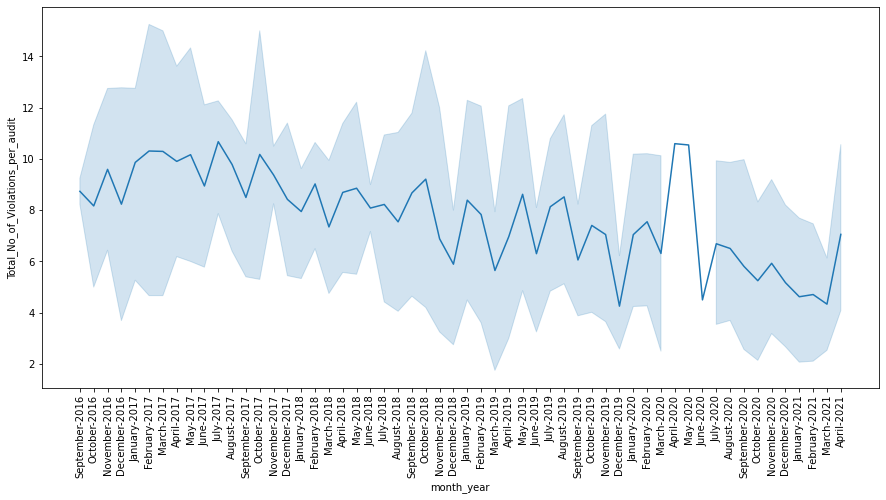

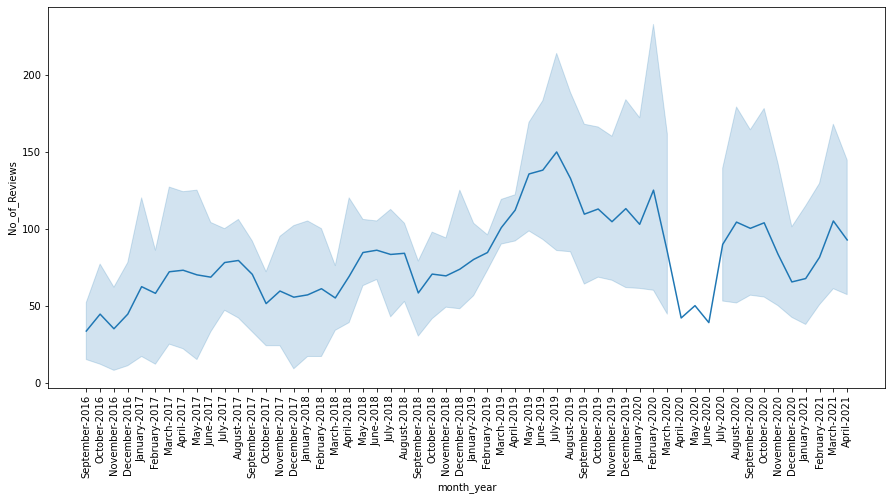

In [10]:
plt.figure(figsize=(15,7))
ax = sns.lineplot(y='Total_No_of_Violations_per_audit', x='month_year', data=df_merged)
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(15,7))
ax = sns.lineplot(y='No_of_Reviews', x='month_year', data=df_merged)
plt.xticks(rotation=90)
plt.show()

In [11]:
print("Total No of brands retained :", df_merged.Brand.nunique())
print('\n \n')
print("Name's of the brands used for analysis:", df_merged.Brand.unique())

Total No of brands retained : 6

 

Name's of the brands used for analysis: ["Friendly's" 'Margaritaville' 'Cafe Zupas' 'True Food Kitchen'
 'Modern Market' 'Wood Ranch']


# Approach 1: Overall Brand Analysis

## Descriptive Analysis 

Key Message-
* Brands with <b>Lower number of violations</b> have <b>Positive sentiment scores</b>

### Sentiment & Violations/Audit Distribution acrosss brands 1/3

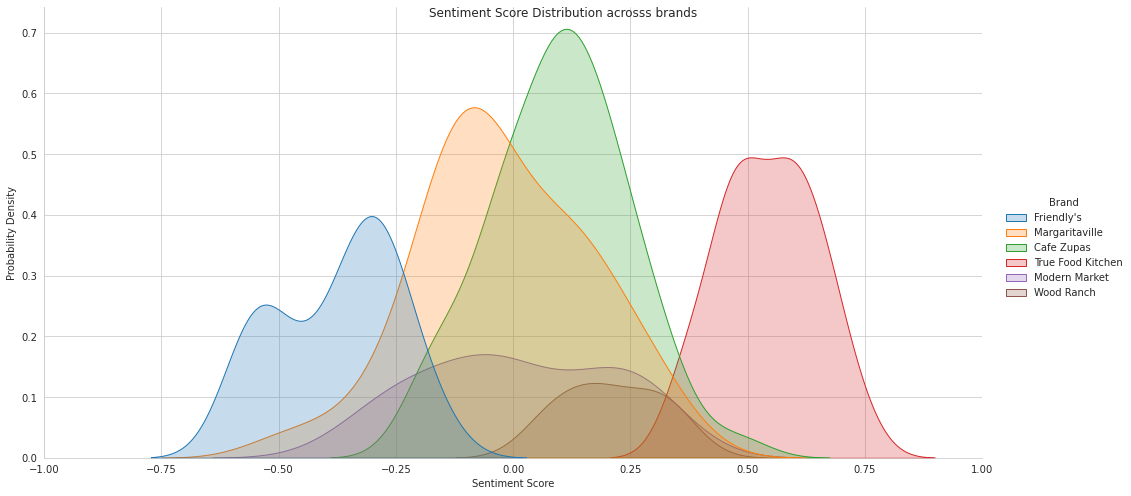

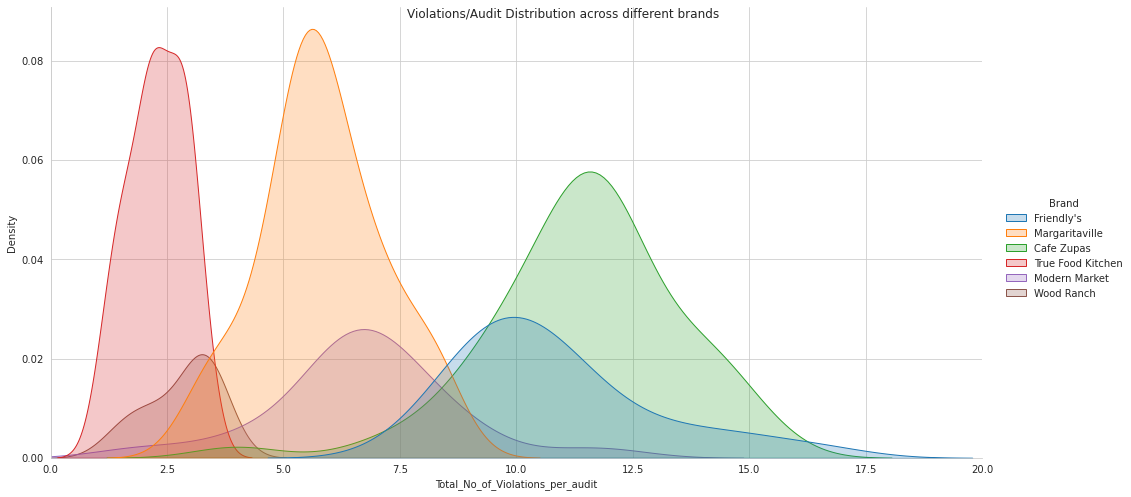

In [12]:
sns.set_style("whitegrid")
ax = sns.displot(data=df_merged[df_merged.Brand.isin(["Friendly's", 'Margaritaville', 'Cafe Zupas', 'True Food Kitchen', 'Modern Market', 'Wood Ranch'])],
                 x='Flair_Score', hue='Brand', kind='kde', fill=True, height=7, aspect=2)
ax.set(xlim=(-1,1))
ax.set(xlabel = 'Sentiment Score', ylabel = 'Probability Density')
ax.fig.suptitle("Sentiment Score Distribution acrosss brands",
                  fontsize=12, fontdict={"weight": "bold"})


ax = sns.displot(data=df_merged[df_merged.Brand.isin(["Friendly's", 'Margaritaville', 'Cafe Zupas', 'True Food Kitchen', 'Modern Market', 'Wood Ranch'])],
                 x='Total_No_of_Violations_per_audit', hue='Brand', kind='kde', fill=True, height=7, aspect=2)
ax.set(xlim=(0,20))
ax.fig.suptitle("Violations/Audit Distribution across different brands",
                  fontsize=12, fontdict={"weight": "bold"})
plt.show()

### Violations per Audit across different sentiment buckets (Normalized By: No of Reviews)

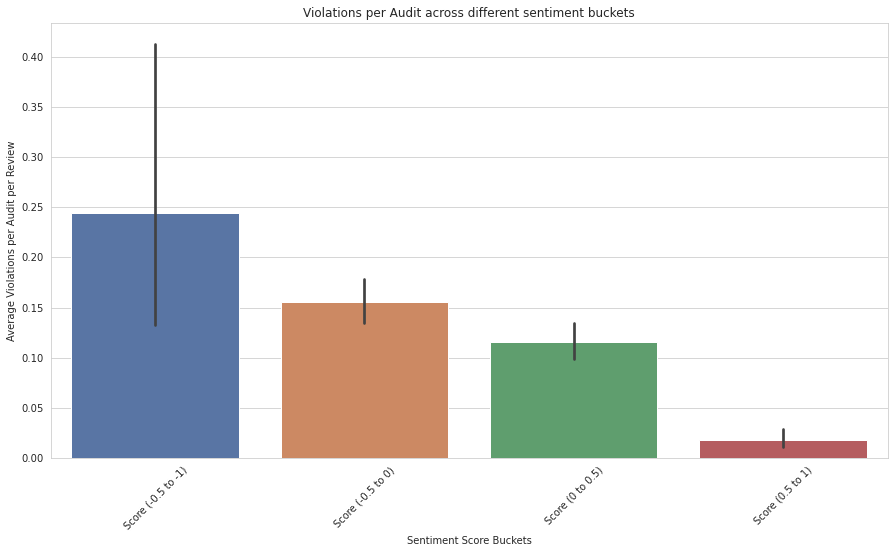

In [13]:
df_dist_senti = df_merged.copy(deep=True)
df_dist_senti['sentiment_bucket'] = df_dist_senti['Flair_Score'].apply(req_intervals)

df_dist_senti['Total_No_of_Violations_per_audit'] = df_dist_senti['Total_No_of_Violations_per_audit']/df_dist_senti['No_of_Reviews']

plt.figure(figsize=(15,8))
ax = sns.barplot(x='sentiment_bucket', y='Total_No_of_Violations_per_audit', data=df_dist_senti, palette = 'deep')
ax.set(xlabel = 'Sentiment Score Buckets', ylabel = 'Average Violations per Audit per Review')
ax.set_title('Violations per Audit across different sentiment buckets')
plt.xticks(rotation=45)
plt.show()

Findings-
* <b>As the average violations per audits per review decreases, the sentiment scores increases (tends towards positive)<b/>

### Violations per Audit across different ratings (Normalized By: No of Reviews)

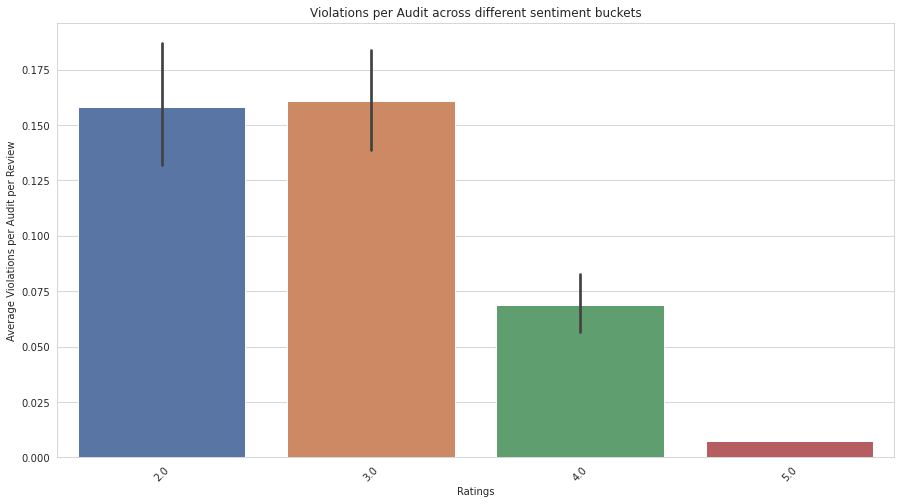

In [14]:
df_dist_senti = df_merged.copy()
df_dist_senti['Rating'] = round(df_dist_senti['Rating'],0)

df_dist_senti['Total_No_of_Violations_per_audit'] = df_dist_senti['Total_No_of_Violations_per_audit']/df_dist_senti['No_of_Reviews']

plt.figure(figsize=(15,8))
ax = sns.barplot(x='Rating', y='Total_No_of_Violations_per_audit', data=df_dist_senti, palette = 'deep')
ax.set(xlabel = 'Ratings', ylabel = 'Average Violations per Audit per Review')
ax.set_title('Violations per Audit across different sentiment buckets')
plt.xticks(rotation=45)
plt.show()

Findings-
* <b>As the average violations per audit per review decreases, the review ratings increases (tends towards positive)</b>

# Approach 2: Across Brands 

Key Messages-
* From Correlation Matrix with Initial Dataset, there is <b>negative correlation between Violations per Audit and Customer Sentiment Measures</b>
* With more <b>Refined Dataset</b>, the <b>correlation</b> becomes <b>more stronger between our Drivers(Mean Audit Score, Violations per Audit) and Measures of Delighted Guests(Sentiment Score, Ratings) </b>
* Same relationship is observed across <b>feature importance and hypothesis testing methods</b> as well

##  Correlation Matrix

### Data Aggregated at Month-Year & Brand Level

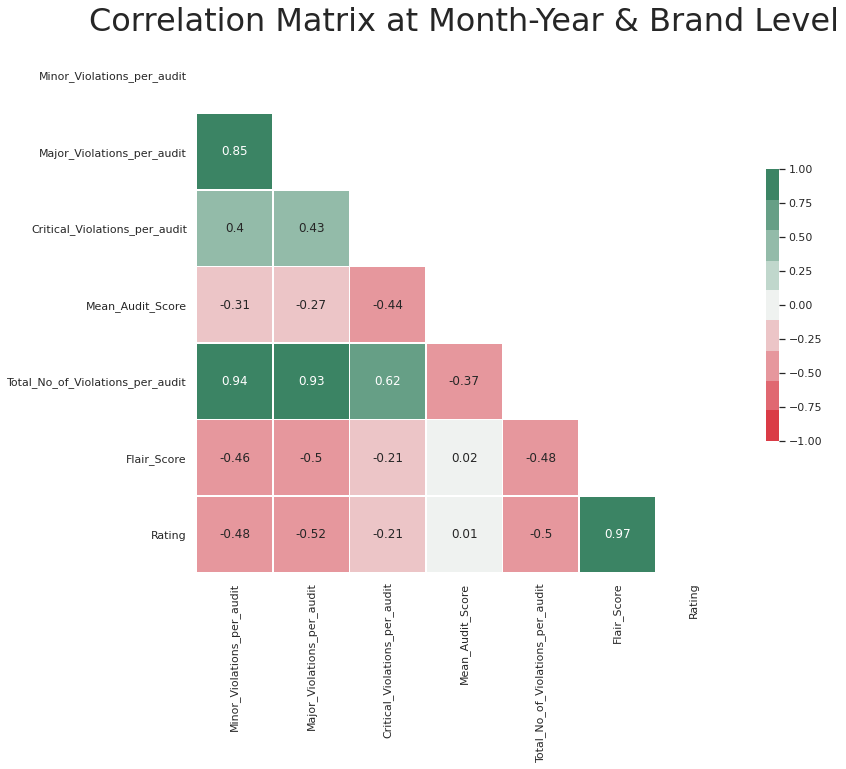

In [15]:
var = ['Minor_Violations_per_audit', 'Major_Violations_per_audit', 'Critical_Violations_per_audit',
       'Mean_Audit_Score', 'Total_No_of_Violations_per_audit', 'Flair_Score', 'Rating']

correlation_matrix(var, df_merged, "Correlation Matrix at Month-Year & Brand Level")

<b>Criteria for refining dataset:</b>
* Calculated number of audits (normalised by number of stores per brand)
* Calculated median for Audits per Store and Number of reviews
* Filtered for data points having audits per store and number of reviews greater than median values i.e <b>Audit_per_store > 0.326, No_of_Reviews > 78</b>

In [18]:
print(round(df_merged.Audit_per_store.median(),3), df_merged.No_of_Reviews.median())

0.327 78.0


## Hypothesis Testing (Refined Data)

Results-
* <b>Increase in Violations per Audit, results in decreased Ratings</b>
* <b>Increase in Total No of Violations per Audit, results in decrease in Sentiment Scores</b>



### Hypothesis 1: Total No of Violations per Audit vs Review Ratings
<br>
<b>Null Hypothesis:</b> Increase in Violations per Audit does not affect ratings
 
<b>Alternate Hypothesis:</b> Increase in Violations per Audit, results in decreased ratings

In [19]:
df_merged[df_merged['Rating'].notnull() & (df_merged.Audit_per_store > df_merged.Audit_per_store.median()) & (df_merged.No_of_Reviews > df_merged.No_of_Reviews.median())].shape

(47, 20)

In [20]:
spearman_corr(df_merged[df_merged['Rating'].notnull() & (df_merged.Audit_per_store > df_merged.Audit_per_store.median()) & (df_merged.No_of_Reviews > df_merged.No_of_Reviews.median())], 'Total_No_of_Violations_per_audit', 'Rating')

,Spearman Coefficient,p-value,Null Hypothesis,Atlernate Hypothesis
0,-0.72,0.00,Rejected,Accepted


### Hypothesis 2: Total No of Violations per Audit vs Sentiment Scores
<br>
<b>Null Hypothesis:</b> Increase in Total No of Violations per Audit does not affect sentiment scores
 
<b>Alternate Hypothesis:</b> Increase in Total No of Violations per Audit, results in decrease in sentiment scores

<b>Spearman Correlation Coefficient</b>

In [21]:
spearman_corr(df_merged[df_merged['Flair_Score'].notnull() & (df_merged.Audit_per_store > df_merged.Audit_per_store.median()) & (df_merged.No_of_Reviews > df_merged.No_of_Reviews.median())], 'Total_No_of_Violations_per_audit', 'Flair_Score')

,Spearman Coefficient,p-value,Null Hypothesis,Atlernate Hypothesis
0,-0.72,0.00,Rejected,Accepted
